<a href="https://colab.research.google.com/github/FANCY000000/Asset_Class_Detection_for_Mutual_Funds_Using_NLP/blob/main/Asset_Class_Detection_for_Mutual_Funds_Using_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction and Background

In the ClearView database and some commonly-used websites such Fundata, the classification of a certain mutual fund is simply labeled as 'Equity' or 'Alternatives', which contradicts its asset allocation. While Bloomberg Terminal does have its classification for funds but the data is limited and we aim to generalized the techniques in a broader scope.
 
This project proposes to determine the accurate asset class of the fund based on its description. The project starts from scraping principal investment strategies of American mutual funds from US Securities and Exchange Commission (SEC). Afterward, we did some data cleaning and data exploration. Finally, We implement machine learning (Naive Bayesian, K-Nearest Neighbors, and Random Forest) and deep learning algorithms (Long Short-Term Memory and Bidirectional Encoder Representations from Transformers) to train and predict the corresponding asset class, using the asset class provided by Bloomberg as a label.
 
Such fund classification could be further used to justify whether the existing blended benchmark is a good fit for a certain asset portfolio, or to find the optimal ratio of each blended benchmark component, thus helping our clients make better investment decisions.

**Important notice:**

All file paths in the code need to be changed into the file path on your own google drive. 

'/content/drive/My Drive/4511 industry project/data_sec' -> '/content/drive/My Drive/your_file_path'

# Preprocessing

## Data Gathering

**Important Notice:**In this part, if you run the code in Colab, you must set the runtime type as 'None'. If not, the sec website will block the requests. But sometimes the website will still block the requests becuase of exceeding the request rate, **so the better and safer way is to run this part in offline software like Jupyter notebook**

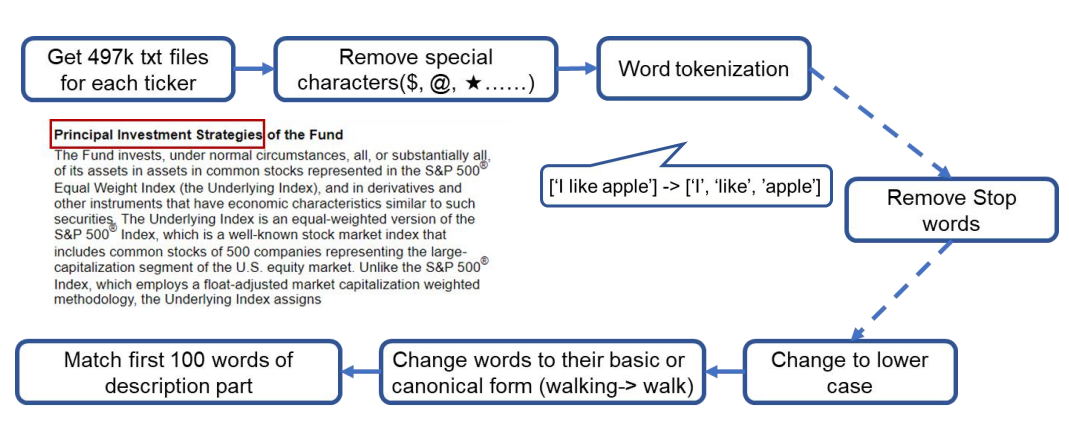

**All Possible Data Source:**

*   SEC(https://www.sec.gov/edgar/searchedgar/mutualsearch.html): basic identification information for all active investment entities and their regulatory filings, including summary prospectus which contains detailed principal investment strategies 
*   StockMarket (https://stockmarketmba.com/): three-dimension class classifications
*   Bloomberg: university library source
*   Yahoo (https://www.yahoo.com/)
*   Morningstar (https://www.morningstar.com/funds)
*   Fundata(https://www.fundata.com/): Canadian funds


In [ ]:
import bs4 as bs
from bs4 import BeautifulSoup
import requests

import pandas as pd
import numpy as np
import re
import os
import string

#from unidecode import unidecode
print('Importing nltk...')
import nltk
from nltk import word_tokenize
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
print('Succeed in importing nltk...')

import re


Importing nltk...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
Succeed in importing nltk...


In [ ]:
pip install html2text

In [ ]:
import html2text 

In [ ]:
# connect to your own google drive
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/4511 industry project/data_sec')

Mounted at /content/drive


**First Step:** Get the link

In [ ]:
#Input the ticker of mutual fund
df = pd.read_excel('unionticker.xls')

count = 0
text_df = dict()
#find according 497k or 497 files according to those links
for ticker in df['Ticker']:
    response = requests.get(f'https://www.sec.gov/cgi-bin/series?ticker={ticker}&CIK=&sc=companyseries&type=N-PX&Find=Search')
    results_page = BeautifulSoup(response.content,'lxml')
    if results_page.find('a',{'class':"nav"}):
        link_list=list()
        l = results_page.find('a',{'class':"nav"}).get('href')
        ll = 'https://www.sec.gov/' + l
        p2= '&type=497'
        p3= '&type=497K'
        link_list.append(ll + p3)
        link_list.append(ll + p2)
        for link in link_list:
            s = 0
            if link:
                if s == 0:
                    s += 1
                    USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1.2 Safari/605.1.15'
                    headers = {"user-agent" : USER_AGENT}
                    response2 = requests.get(url = link,headers = headers)
                    soup2 = BeautifulSoup(response2.content,'html.parser')
                    temp_list = []
                    for link_pack in soup2.find_all('a'):
                        if link_pack['href'][0:9] == '/Archives':
                                temp_list.append('https://www.sec.gov'+link_pack['href'][:-10] + '.txt')
                                text_df[ticker] = temp_list[0]
                                count += 1
                                if count%10 == 0:
                                    print(count)
                                break
                    if temp_list:
                        break
                else:
                    USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1.2 Safari/605.1.15'
                    headers = {"user-agent" : USER_AGENT}
                    response2 = requests.get(url = link,headers = headers)
                    soup2 = BeautifulSoup(response2.content,'html.parser')
                    for link_pack in soup2.find_all('a'):
                        if link_pack['href'][0:9] == '/Archives':
                                text_df[ticker] = 'https://www.sec.gov'+link_pack['href'][:-10] + '.txt'
                                count += 1
                                if count%10 == 0:
                                    print(count)
                                break

In [ ]:
#output the link we got
df_link = pd.DataFrame.from_dict(text_df,orient='index',columns = ['txt'])
df_link = df_link.reset_index().rename(columns = {'index':'ticker'})
df_link.to_excel('txt_link.xls',index=None)

**Second Step:** Get 100-word descriptions

*   remove the sepcial characters($, @, ★ ......)
*   word tokenization(['I like apple'] -> ['I','like','apple'])
*   Change to lower case
*   Change words to their basic and canonical forms(walking -> walk)
*   match first 100 words of description part
    *   use three key words to match: 'principal', 'strategy', 'investment'
    *   if the paragraph contains 2 of those key words, then we will extract 100 words from next paragraph






In [ ]:
def remove_other(text):
    remove_chars = '[’!"#$%&\'()*+,-./:;<=>?@，。?★、…【】《》？“”‘’！[\\]^_`{|}~]+'
    return re.sub(remove_chars, '', text)


## clean the paragraph and return the word list
def clean_text(text,remove_stopword):
    
    # remove chars that are not number or alpha
    text = remove_other(text)
    
    # correct typo (not necessary because we believe our data to be formatted)
    
    # lemmatization; remove stopwords; convert to lower cases
    lemma_tool = WordNetLemmatizer()

    if remove_stopword:
        stopset = stopwords.words('english') + list(string.punctuation)
        newSubject = [ lemma_tool.lemmatize( word.lower() ) for word in word_tokenize(text) if word!='' and word not in stopset]
    else:
        newSubject = [ lemma_tool.lemmatize( word.lower() ) for word in word_tokenize(text) if word!='']

    # convert list to text
    newSubject = " ".join(newSubject) 
    return newSubject

In [ ]:
def split_para_by_line(data,remove_stopword):
    res1 = html2text.html2text(str(data))      
    line_l = res1.splitlines()
    n = len(line_l)
    para_l = []
    i = j = 0
    nex,cur_para = '',''
    while (i<n-1):
        cur = line_l[0] if i==0  else nex
        nex = line_l[i+1]
        cur_para += ' '+cur
        if nex == '':
            cur_para = clean_text(cur_para,remove_stopword)
            if len(cur_para)>5:
                para_l.append([cur_para] )
                j += 1
                #print(cur_para)
            cur_para  = ''
        i+=1
    return para_l


In [ ]:
def find_count_keywrod(word_list,key_word,count):
    c = 0
    for i in key_word:
        if i in word_list:
            c += 1
        if c == count:
            break
    if c == count:
        return 1
    else:
        return 0
    
def catch_100words_desc(link):
    try:
        USER_AGENT = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/11.1.2 Safari/605.1.15'
        headers = {"user-agent" : USER_AGENT}
        response2 = requests.get(url = link,headers = headers)
        soup2 = BeautifulSoup(response2.content,'html.parser')
        para_l = split_para_by_line(soup2,0)
        catch_para = ''
        for i in range(len(para_l)):
            word_list = word_tokenize(para_l[i][0])
            key_word = ['principal','strategy','investment']
            if find_count_keywrod(word_list,key_word,2):
                len_catch = 0
                for j in range(i+1,len(para_l)):
                    word_list_k = word_tokenize(para_l[j][0])
                    if len(word_list_k) <= (100-len_catch):
                        catch_para += para_l[j][0] + ' '
                        len_catch += len(word_list_k)
                    else:
                        catch_para += ' '.join(word_list_k[: 100 -len_catch])

                        break
                break
        return catch_para
    except:
        return None

In [ ]:
def crawl_from_sec_links(txt_file_name):

  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/My Drive/4511 industry project/data_sec')

  df= pd.read_excel(txt_file_name)
  df['desc'] = None

  count = 0
  for index, row in df.iterrows():
  #     print('start',index)
      catch_des = catch_100words_desc(row[1])
      time.sleep(0.5)
      if catch_des:
          count += 1
          if count%10 == 0:
              print('sucess at', row[0],'index is',index)
          df.at[index,'desc']= catch_des
  df.to_csv('data.csv')

In [ ]:
crawl_from_sec_links('txt_link.xls')

## Data merging

Use the key 'ticker' to merge descriptions from sec website('**data.csv**') we obtained with the code above and the class data from Bloomberg through excel. After that we eliminate some abnormal data, then we get the file named **'matchoutput_ver2_clean.csv'**

## Data Cleaning

*   Remove stop words(1: remove stop words, 0: do not remove stop words)
*   Split the data into trian data and test data with ratio of 8: 2
*   change the class of data into One-hot vector

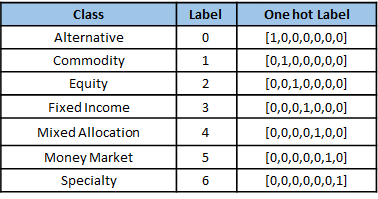

In [ ]:
def add_one_hot(data,column_name):
    one_hot = pd.get_dummies(data[column_name])
    one_hot_in_one = one_hot.apply(lambda x: list(x),axis = 1)
    one_hot_in_one.name = column_name+'_One_hot'
    return data.join(one_hot_in_one)

In [ ]:
def split_data(data_use,*ratio):
    print(ratio)
    if len(ratio) == 2:
        train_ratio = ratio[0]
        valid_ratio = 0
    if len(ratio) == 3:
        train_ratio = ratio[0]
        valid_ratio = ratio[1]

    n = len(data_use)
    u1 = int(n*train_ratio)
    u2 = int ( n*(train_ratio+valid_ratio) )
    train_set = data_use[: u1 ]
    valid_set = data_use[ u1 : u2]
    test_set = data_use[ u2 :]
    return train_set,valid_set,test_set

In [ ]:
def output_train_test_data(data,REMOVE_STOP_WORD):

  data['Description'] = data.apply(lambda x:  clean_text(x['Description'], REMOVE_STOP_WORD) ,axis =1) 

  data_use = data[['Description','Class_One_hot']]

  train_set,valid_set,test_set = split_data(data_use,0.8,0.2)
  train_set.to_csv('train_set_'+str(REMOVE_STOP_WORD)+'.csv',index=0)
  if len(valid_set)>0:
      valid_set.to_csv('valid_set_'+str(REMOVE_STOP_WORD)+'.csv',index=0)
  test_set.to_csv('test_set_'+str(REMOVE_STOP_WORD)+'.csv',index=0)

In [ ]:
def prepare_data():

  from google.colab import drive
  drive.mount('/content/drive')
  os.chdir('/content/drive/My Drive/4511 industry project/data_sec')
  # read the cleaned merged data
  data = pd.read_csv('matchoutput_ver2_clean.csv',encoding ='iso-8859-1' )
  data.dropna(axis=0, how='any', inplace=True)
  data.columns = ['Ticker','Link','Description','Class']
  data = add_one_hot(data,'Class')

  output_train_test_data(data,1)
  output_train_test_data(data,0)

In [ ]:
prepare_data()

# Data Exploration

*   Explore the proportion of each asset class in the training dataset.
*   Draw and compare wordclouds of text descriptions for different asset class.
*   define confusion matrix function for future use.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/4511 industry project/data_sec')
mapping_table = pd.read_excel("mapping_table.xlsx",header=0)
df_train = pd.read_csv("train_set_1.csv",converters={'Class_One_hot': eval })
df_test = pd.read_csv("test_set_1.csv",converters={'Class_One_hot': eval}) 

Mounted at /content/drive


In [ ]:
df_train.columns = df_test.columns = ['X','y']
text_train_class = np.argmax(np.array(list(df_train['y'])) ,axis=1)
df_train_new = pd.concat( [df_train['X'],pd.Series(text_train_class)], axis=1)
df_train_new.columns = ['text','class']
df_train_new = df_train_new.dropna()

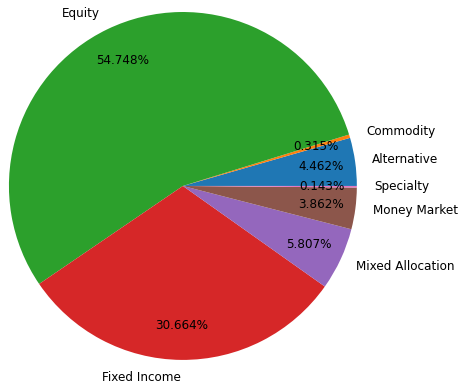

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
df_pie = df_train_new.copy()
df_pie.columns = ['text','Label']
df_pie_new = pd.merge(df_pie,mapping_table,on='Label',how='inner')
grouped = df_pie_new.groupby('Class').count()['text']
plt.pie(x=grouped.values,
        labels=grouped.index,
        autopct='%.3f%%',
        pctdistance=0.8,
        radius=2,
        textprops= {'fontsize':12,'color':'black'})
plt.show()

In total, there are seven asset classes  with obviously different percentage of data in our dataset.   

The pie chart shows that more than half mutual funds in our training dataset are Equity, followed by Fixed income, which accounted for about 30%. Other four categories account for less than 6% respectively. It is obvious that our training data is imbalanced.   

As a result, we suppose that our models would have lower precision on asset classes with low percentage than Equity and Fixed Income ones.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

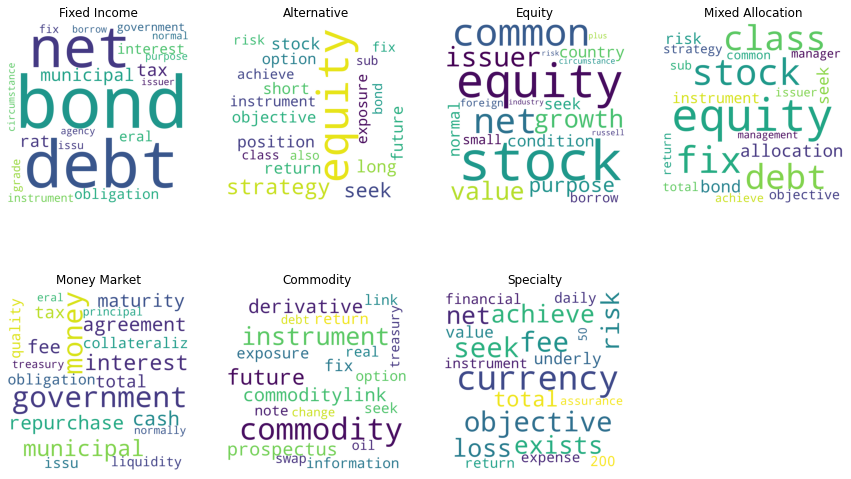

In [ ]:
#merge text in the same classification
text_dict = dict()
for c in df_train_new['class'].unique():
  text_total = str()
  for i in range(len(df_train_new)):
    if df_train_new['class'].iloc[i]== c:
      text_total += df_train_new['text'].iloc[i]
  name = mapping_table[mapping_table['Label']==c].Class.iloc[0]
  text_dict[name]=text_total

#draw word clouds
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
%matplotlib inline

#Remove unwanted words
#As we look at the cloud, we can get rid of words that don't make sense by adding them to this variable
DELETE_WORDS = ['the','fund','company','80','market','investment','invest','invests','index',
                    'may','security','asset','ing','emerg','advisor','adviser','includ','ed','income',
                    'time','least','inclduing','portfolio','primarily','capitalization']
def remove_words(text_string,DELETE_WORDS=DELETE_WORDS):
    DELETE_WORDS = ['the','fund','company','80','market','investment','invest','invests','index',
                    'may','security','asset','ing','emerg','advisor','adviser','includ','ed','income',
                    'time','least','inclduing','portfolio','primarily','capitalization']
    for word in DELETE_WORDS:
        text_string = text_string.replace(word,' ')
    return text_string

#Remove short words
MIN_LENGTH = 1
def remove_short_words(text_string,min_length = MIN_LENGTH):
    word_list = text_string.split()
    for word in word_list:
        if len(word) < min_length:
            text_string = text_string.replace(' '+word+' ',' ',1)
    return text_string

#TfidfVecorizer
def tfidf_words(text_string):
    from sklearn.feature_extraction.text import TfidfVectorizer
    text_string=text_string.split(', ')
    vectorizer = TfidfVectorizer()
    vecs = vectorizer.fit_transform(text_string)
    feature_names = vectorizer.get_feature_names()
    dense = vecs.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    return df.T.sum(axis=1)

#Set up side by side clouds
COL_NUM = 4
ROW_NUM = 2
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(15,9), squeeze=False)
fig.delaxes(axes.flatten()[7])

for i in range(len(text_dict)):
    text_string = remove_words(text_dict[list(text_dict.keys())[i]])
    text_string = remove_short_words(text_string)
    text_string = tfidf_words(text_string)
    ax = axes[i//4, i%4]
    ax.set_title(list(text_dict.keys())[i])
    wordcloud = WordCloud(stopwords=STOPWORDS,background_color='white',width=1200,height=1200,max_words=20).generate_from_frequencies(text_string)
    ax.imshow(wordcloud)
    ax.axis('off')

plt.show()

We also draw word clouds of each asset class after removing some common words by TF-IDF (term frequency–inverse document frequency)  algorithm and manually remove some valueless words (invest, fund, company, etc)).

As is shown in the word clouds, word preference for different asset classes varies from each other. For instance, words, such as debt, bond and RAT, appear frequently in Fixed Income mutual funds. Government and money represent unique importance for Money Market ones.  

However, the category name itself may not be a good predictor. Though commodity is unique for its class, equity appears frequently not only in Equity class, but also in Alternative and Mixed Allocation class, which would enhance the difficulty to distinguish them.

In [ ]:
def compute_count(data,column_name):
    n = len(data)
    class_count_df = data.groupby([column_name]).count().sort_values(by = 'Ticker') [['Ticker']]
    class_count_df.columns = ['Sum']
    class_count_df['Cum_sum'] = class_count_df['Sum'].cumsum()/n
    print(class_count_df )
    return class_count_df

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics

def plot(target_class,y_pred_class,model_name):
  %matplotlib inline
  con_mat = confusion_matrix(target_class, y_pred_class)
  con_mat_norm = con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis]
  con_mat_norm = np.around(con_mat_norm, decimals=2)
  sns.heatmap(con_mat_norm, annot=True, cmap='Blues')
  plt.title('Confusion Matrix of '+model_name)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.show()

  outputs = y_pred_class
  accuracy = metrics.accuracy_score(target_class, y_pred_class)
  f1_score_micro = metrics.f1_score(target_class, y_pred_class, average='micro')
  f1_score_macro = metrics.f1_score(target_class, y_pred_class, average='macro')
  print(f"Accuracy Score = {accuracy}")
  print(f"F1 Score (Micro) = {f1_score_micro}")
  print(f"F1 Score (Macro) = {f1_score_macro}")

# Modeling and Evaluation

In the modeling and evaluation section, we use machine learing (Bayesian, KNN, RF) and deep learing methods (LSTM, Bert) to predict, and use macro-F1, micro-F1 and confusion matrix to evaluate the prediction results.

Convert data from dataframe to array for future usage.

In [ ]:
X_train,y_train = np.array(df_train['Description']), np.array( list( df_train['Class_One_hot']) )
X_test,y_test = np.array(df_test['Description']), np.array( list( df_test['Class_One_hot']) )

## Machine learning

In ML models, we use Pipeline to facilitate the process.

The first step is to build some selectors.

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin

class TextSelector(BaseEstimator, TransformerMixin):

    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]


In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

### Naive Bayesian

**Model 1**: TF-IDF + bayesian

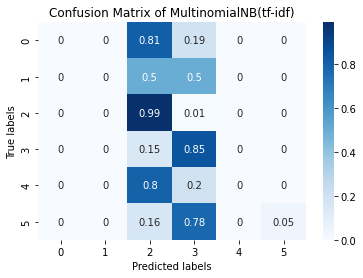

Accuracy Score = 0.8354285714285714
F1 Score (Micro) = 0.8354285714285714
F1 Score (Macro) = 0.307164511262872


In [ ]:
from sklearn.naive_bayes import MultinomialNB
pipeline1 = Pipeline([
    ('selector', TextSelector(key='Description')),
    ('tfidf', TfidfVectorizer( )),
    ('classifier', MultinomialNB())
])

pipeline1.fit( df_train, np.argmax(y_train,axis=1))
preds = pipeline1.predict(df_test)

plot(np.argmax(y_test,axis=1),preds,'MultinomialNB(tf-idf)')

**Model 4**: one hot + bayesian

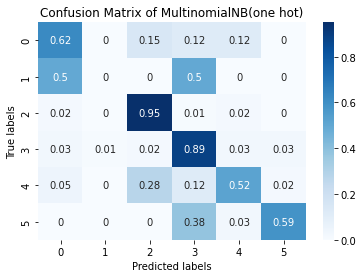

Accuracy Score = 0.8834285714285715
F1 Score (Micro) = 0.8834285714285716
F1 Score (Macro) = 0.5827391252305828


In [ ]:
pipeline4 = Pipeline([
    ('selector', TextSelector(key='Description')),
    ('onehot', CountVectorizer()),
    ('classifier', MultinomialNB())
])

pipeline4.fit(df_train, np.argmax(y_train,axis=1))
preds = pipeline4.predict(df_test)

plot(np.argmax(y_test,axis=1),preds,'MultinomialNB(one hot)')

Basic Assumption of Bayesian: Each Feature in a sample is independent of any other one. 

We know that it is not the case in our text. The word must have relationship with words forward and backward. The reason why it stills performs well may because of its simple structure determines it to have strong generalization ability. Plus, some explain that the negative and positive effects of independent assumptions may finally offset.


### KNN

**Model 2**: TF-IDF + KNN

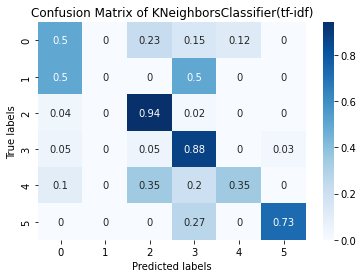

Accuracy Score = 0.8731428571428571
F1 Score (Micro) = 0.873142857142857
F1 Score (Macro) = 0.5691617477306795


In [ ]:
from sklearn.neighbors import KNeighborsClassifier
pipeline2 = Pipeline([
    ('selector', TextSelector(key='Description')),
    ('tfidf', TfidfVectorizer( )),
    ('classifier', KNeighborsClassifier())
])

pipeline2.fit(df_train, y_train)
preds = pipeline2.predict(df_test)

plot(np.argmax(y_test,axis=1),np.argmax(preds,axis=1),'KNeighborsClassifier(tf-idf)')

**Model 5**: one hot + KNN

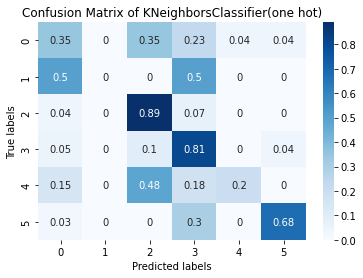

Accuracy Score = 0.8102857142857143
F1 Score (Micro) = 0.8102857142857143
F1 Score (Macro) = 0.48742127574619104


In [ ]:
pipeline5 = Pipeline([
    ('selector', TextSelector(key='Description')),
    ('onehot', CountVectorizer( )),
    ('classifier', KNeighborsClassifier())
])

pipeline5.fit(df_train, y_train)
preds = pipeline5.predict(df_test)

plot(np.argmax(y_test,axis=1),np.argmax(preds,axis=1),'KNeighborsClassifier(one hot)')


TF-IDF brings a large improvement. In one-hot method, the value is 0 or 1, means whether the i-th word appears in the j-th description. In TF-IDF, each value has more meanings, related with how many times a word appears in a document, and the inverse document frequency of the word across a set of documents.

### RF

**Model 3**: TF-IDF + RF

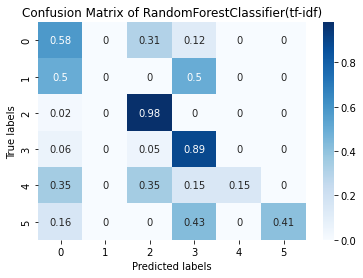

Accuracy Score = 0.8788571428571429
F1 Score (Micro) = 0.8788571428571429
F1 Score (Macro) = 0.5059272008652851


In [ ]:
from sklearn.ensemble import RandomForestClassifier

pipeline3 = Pipeline([
    ('selector', TextSelector(key='Description')),
    ('tfidf', TfidfVectorizer( )),
    ('classifier', RandomForestClassifier(random_state = 42))
])

pipeline3.fit(df_train, y_train)
preds = pipeline3.predict(df_test)

plot(np.argmax(y_test,axis=1),np.argmax(preds,axis=1),'RandomForestClassifier(tf-idf)')

**Model 6**: one-hot + RF

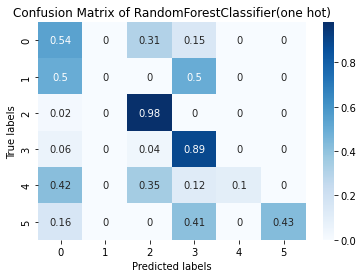

Accuracy Score = 0.8765714285714286
F1 Score (Micro) = 0.8765714285714286
F1 Score (Macro) = 0.49146980050116656


In [ ]:
pipeline6 = Pipeline([
    ('selector', TextSelector(key='Description')),
    ('onehot', CountVectorizer( )),
    ('classifier', RandomForestClassifier(random_state = 42))
])

pipeline6.fit(df_train, y_train)
preds = pipeline6.predict(df_test)

plot(np.argmax(y_test,axis=1),np.argmax(preds,axis=1),'RandomForestClassifier(one hot)')

One important edge of using pipeline is that it is very convinient to optimize parameters.

In [ ]:
pipeline3.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'selector', 'tfidf', 'classifier', 'selector__key', 'tfidf__analyzer', 'tfidf__binary', 'tfidf__decode_error', 'tfidf__dtype', 'tfidf__encoding', 'tfidf__input', 'tfidf__lowercase', 'tfidf__max_df', 'tfidf__max_features', 'tfidf__min_df', 'tfidf__ngram_range', 'tfidf__norm', 'tfidf__preprocessor', 'tfidf__smooth_idf', 'tfidf__stop_words', 'tfidf__strip_accents', 'tfidf__sublinear_tf', 'tfidf__token_pattern', 'tfidf__tokenizer', 'tfidf__use_idf', 'tfidf__vocabulary', 'classifier__bootstrap', 'classifier__ccp_alpha', 'classifier__class_weight', 'classifier__criterion', 'classifier__max_depth', 'classifier__max_features', 'classifier__max_leaf_nodes', 'classifier__max_samples', 'classifier__min_impurity_decrease', 'classifier__min_samples_leaf', 'classifier__min_samples_split', 'classifier__min_weight_fraction_leaf', 'classifier__n_estimators', 'classifier__n_jobs', 'classifier__oob_score', 'classifier__random_state', 'classifier__verbose', 'classi

In [ ]:
from sklearn.model_selection import GridSearchCV

hyperparameters = { #'tfidf__max_df': [0.9, 0.95],
            #'tfidf__ngram_range': [(1,1), (1,2)],
            'classifier__max_depth': [50, 100],
            #'classifier__min_samples_leaf': [1,5]
                  }
clf = GridSearchCV(pipeline3, hyperparameters, cv=5)
 
clf.fit(df_train, y_train)

print(clf.best_params_)

{'classifier__max_depth': 100}


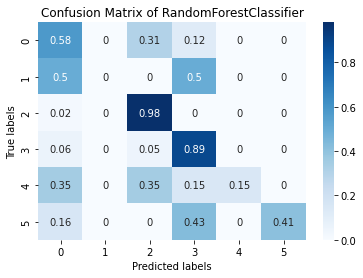

Accuracy Score = 0.8788571428571429
F1 Score (Micro) = 0.8788571428571429
F1 Score (Macro) = 0.5059272008652851


In [ ]:
clf.refit

preds = clf.predict(df_test)
plot(np.argmax(y_test,axis=1),np.argmax(preds,axis=1),'RandomForestClassifier')

## LSTM

In this section, we use LSTMs with pre-trained embedding and no pre-trained embedding to predict.

Firstly, be sure to check if cuda could be used in the device, because it is significantly faster than using cpu.

In [ ]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print (device)

cpu


We use [10k embedding](https://github.com/ssehrawat/10K-word-embeddings.git) as pre-trained embedding.

In [ ]:
os.chdir('/content/drive/My Drive/4511 industry project/pre_trained')

import torch
embed = torch.load('10k_word_embeddings.tar')
vocab_to_int = torch.load('vocab_to_int.tar')

Further split the train data to train data and valid data to control the training epochs.

In [ ]:
from sklearn.model_selection import train_test_split

X_train = df_train['Description']
y_train = df_train['Class_One_hot']

X_test_text = df_test['Description']
y_test = df_test['Class_One_hot']

X_train_text,X_val_text,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,stratify=df_train['Class_One_hot'],random_state=123)

print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)
print(X_test_text.shape,y_test.shape)

(2796,) (2796,)
(700,) (700,)
(875,) (875,)


Check the number of unique words in all train data.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

all_words = ''.join(X_train_text) 
all_words = word_tokenize(all_words) 
dist = FreqDist(all_words) 
num_unique_word = len(dist)

print(f'The number of unique words in all train words is {num_unique_word}.')

The number of unique words in all train words is 6663.


**Attention**: Determine some paramters for network.

In [ ]:
MAX_FEATURES = num_unique_word
TRAIN_BATCH_SIZE =  VALID_BATCH_SIZE =8
TEST_BATCH_SIZE = 4

NUM_CLASSES = len( y_train.iloc[0] )
MAX_LEN = 100
HIDDEN_DIM = 128
NUM_LAYERS = 2
BILSTM = False
PATIENCE = 3
EPOCHS = 50
MIN_EPOCHS = 10
LEARNING_RATE = 1e-03

Tokenize the words in training data.

In [ ]:
tokenizer = Tokenizer(num_words = MAX_FEATURES)
tokenizer.fit_on_texts(list(X_train_text))

word_index = tokenizer.word_index
print(word_index)

{'fund': 1, 'security': 2, 'investment': 3, 'company': 4, 'market': 5, 'asset': 6, 'stock': 7, 'may': 8, 'least': 9, 'invests': 10, 'u': 11, 'invest': 12, 'equity': 13, '80': 14, 'index': 15, 'net': 16, 'capitalization': 17, 'normal': 18, 'investing': 19, 'income': 20, 'portfolio': 21, 'issuer': 22, 'including': 23, 'bond': 24, 'purpose': 25, 'adviser': 26, 'primarily': 27, 'common': 28, 'debt': 29, 'condition': 30, 'seek': 31, 'circumstance': 32, 'borrowing': 33, 'value': 34, 'normally': 35, 'foreign': 36, 'instrument': 37, 'plus': 38, 'government': 39, 'objective': 40, 'country': 41, 'interest': 42, 'time': 43, 'tax': 44, 'municipal': 45, 'include': 46, 'growth': 47, 'emerging': 48, 'risk': 49, 'issued': 50, 'obligation': 51, 'total': 52, 'federal': 53, 'management': 54, 'strategy': 55, 'principal': 56, 'state': 57, 'purchase': 58, 'financial': 59, 'fixed': 60, 'return': 61, 'also': 62, 'range': 63, 'small': 64, 'manager': 65, 'fundamental': 66, 'russell': 67, 'amount': 68, 'capital'

Briefly look into how many words are not in the pre-trained embedding.

In [ ]:
count_ = 0
for key in word_index.keys():
  try:
    max_dim_value = np.max( embed[vocab_to_int[key]])
    if max_dim_value>=0.1:
      count_+= 1
    else:
      print(key)
  except:
    if dist[key]>100:
      print(key, '  ',dist[key])
    pass
print(count_)

80    1705
ã¶    352
0    215
nonus    289
1    175
25    172
investmentgrade    166
2021    159
50    157
fixedincome    156
20    145
60    139
assetbacked    136
2000â®    124
31    121
30    101
3717


Tokenize words and pad each sentence to a fixed length.

In [ ]:
from torch.utils.data import Dataset, DataLoader

class CustomRNNDataset(Dataset):
    def __init__(self, X , y, tokenizer, max_len):
        
        self.Description = X
        self.targets = y
        self.max_len = max_len
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.Description)

    def __getitem__(self, index):

        Desciption_sequence = sequence.pad_sequences( self.tokenizer.texts_to_sequences( [self.Description.iloc[index]] ), maxlen = self.max_len)[0]

        return {
            'Desciption': torch.tensor(Desciption_sequence, dtype=torch.long),
            'targets': torch.tensor(self.targets.iloc[index], dtype=torch.float)
        }

In [ ]:
train_set = CustomRNNDataset(X_train_text, y_train, tokenizer, MAX_LEN)
val_set = CustomRNNDataset(X_val_text, y_val, tokenizer, MAX_LEN)
test_set = CustomRNNDataset(X_test_text, y_test, tokenizer, MAX_LEN)

Load data.

In [ ]:
train_params  = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

valid_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
               'num_workers': 0
                }

test_params = {'batch_size': TEST_BATCH_SIZE,
                'shuffle': False,
               'num_workers': 0
                }
train_loader = DataLoader(train_set, **train_params)
val_loader = DataLoader(val_set, **valid_params)
test_loader = DataLoader(test_set, **test_params)

Define loss function, training process and validation process.

In [ ]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [ ]:
def train_model( epoch, lr=0.001):
    optimizer = torch.optim.Adam(params =  model.parameters(), lr=lr)
    model.train()

    loss_l = []
    for _,data in enumerate(train_loader):

        Desciption = data['Desciption'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(Desciption,targets)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        loss_l.append ( loss.item() )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    mean_loss = np.mean(loss_l)
    print(f'Epoch: {epoch}, Training Loss:  {mean_loss }')
    return mean_loss

In [ ]:
def val_model ( epoch ):
    model.eval()
    loss_l = []
    for _,data in enumerate(val_loader):

        Desciption = data['Desciption'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(Desciption,targets)
        loss = loss_fn(outputs, targets)
        loss_l.append ( loss.item() )

    mean_loss = np.mean(loss_l)
    print(f'Epoch: {epoch}, Validation Loss:  { mean_loss }')
    return mean_loss

### With pre-trained embedding

In [ ]:
from torch import nn

class LSTM_pretrained(torch.nn.Module) :
    def __init__(self, embed , hidden_dim, num_classes, num_layers, bidirectional) :

        super().__init__()
        self.embeddings = nn.Embedding(embed.shape[0], embed.shape[1], padding_idx=0)
        self.embeddings.weight.data.copy_(torch.from_numpy(embed))
        self.embeddings.weight.requires_grad = False ## freeze embeddings

        self.lstm = nn.LSTM(embed.shape[1], hidden_dim, batch_first=True, num_layers=num_layers, bidirectional = bidirectional)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(hidden_dim, num_classes)
        
        
    def forward(self, X, y):

        X = self.embeddings(X)
        X = self.dropout(X)
        lstm_out, (hidden, cell) = self.lstm(X)
        return self.linear(hidden[-1])


In [ ]:
model = LSTM_pretrained (embed, HIDDEN_DIM, NUM_CLASSES,NUM_LAYERS,BILSTM)
model.to(device)

LSTM_pretrained(
  (embeddings): Embedding(159647, 300, padding_idx=0)
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
val_l = []
train_l = []

for epoch in range(EPOCHS):
    train_l.append( train_model(epoch,LEARNING_RATE) )
    val_l.append( val_model(epoch) )
    if len(val_l)>=MIN_EPOCHS and sum( [ val_l[-(i+2)] <= val_l[-(i+1)] for i in range(PATIENCE) ]  ) == PATIENCE:
      break


Epoch: 0, Training Loss:  0.28609118589333127
Epoch: 0, Validation Loss:  0.275807399302721
Epoch: 1, Training Loss:  0.27469111238207133
Epoch: 1, Validation Loss:  0.2725674823265184
Epoch: 2, Training Loss:  0.2749345431157521
Epoch: 2, Validation Loss:  0.27332830310545186
Epoch: 3, Training Loss:  0.2754110756090709
Epoch: 3, Validation Loss:  0.27186175689778547
Epoch: 4, Training Loss:  0.2755292229141508
Epoch: 4, Validation Loss:  0.2743131938305768
Epoch: 5, Training Loss:  0.2697848637189184
Epoch: 5, Validation Loss:  0.33812245523387735
Epoch: 6, Training Loss:  0.2449266030745847
Epoch: 6, Validation Loss:  0.26435260474681854
Epoch: 7, Training Loss:  0.2222361052249159
Epoch: 7, Validation Loss:  0.20922602603042667
Epoch: 8, Training Loss:  0.19775379530021123
Epoch: 8, Validation Loss:  0.19006333051418717
Epoch: 9, Training Loss:  0.18719187509268523
Epoch: 9, Validation Loss:  0.1925519208254462
Epoch: 10, Training Loss:  0.17909610049532992
Epoch: 10, Validation Lo

In [ ]:
def plot_history(train_l,val_l):

  import matplotlib.pyplot as plt
  plt.plot(train_l)
  plt.plot(val_l)
  plt.title('Loss of LSTM')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'valid'], loc='upper right')
  plt.show()

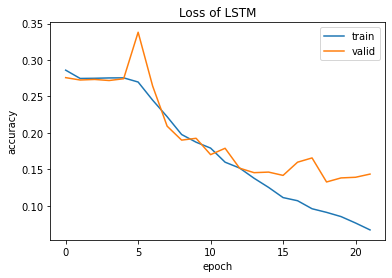

In [ ]:
plot_history(train_l,val_l)

In [ ]:
def test_model ():
    model.eval()
    fin_outputs = []
    for _,data in enumerate(test_loader):

        Desciption = data['Desciption'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(Desciption,targets)
        fin_outputs.extend( torch.sigmoid(outputs).cpu().detach().numpy().tolist() )

    return fin_outputs

In [ ]:
outputs = test_model ()

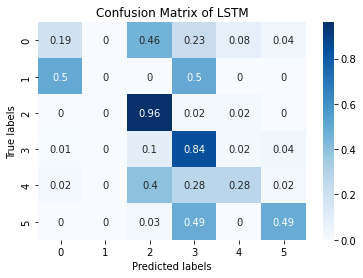

Accuracy Score = 0.848
F1 Score (Micro) = 0.848
F1 Score (Macro) = 0.48001643415191114


In [ ]:
outputs = np.argmax(np.array( outputs ), axis=1) 
targets = np.argmax(np.array( list(y_test) ), axis=1) 
plot(targets,outputs,'LSTM')

### No pre-trained embedding

In [ ]:
class LSTM_origin(torch.nn.Module) :
    def __init__(self, vocab_size, embedding_dim , hidden_dim, num_classes, num_layers, bidirectional) :

        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, batch_first=True, num_layers=num_layers, bidirectional = bidirectional)
        self.dropout = nn.Dropout(0.4)
        self.linear = nn.Linear(hidden_dim, num_classes)
        
        
    def forward(self, X, y):

        X = self.embeddings(X)
        X = self.dropout(X)
        lstm_out, (hidden, cell) = self.lstm(X)
        return self.linear(hidden[-1])

In [ ]:
model = LSTM_origin (MAX_FEATURES, MAX_LEN, HIDDEN_DIM, NUM_CLASSES,NUM_LAYERS,BILSTM)
model.to(device)

LSTM_origin(
  (embeddings): Embedding(6663, 100, padding_idx=0)
  (lstm): LSTM(100, 128, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.4, inplace=False)
  (linear): Linear(in_features=128, out_features=7, bias=True)
)

In [ ]:
val_l = []
train_l = []

for epoch in range(EPOCHS):
    train_l.append( train_model(epoch,LEARNING_RATE) )
    val_l.append( val_model(epoch) )
    if len(val_l)>=MIN_EPOCHS and sum( [ val_l[-(i+2)] <= val_l[-(i+1)] for i in range(PATIENCE) ]  ) == PATIENCE:
      break

Epoch: 0, Training Loss:  0.25151784793606824
Epoch: 0, Validation Loss:  0.19763722882436757
Epoch: 1, Training Loss:  0.16733859640679188
Epoch: 1, Validation Loss:  0.16507833408699793
Epoch: 2, Training Loss:  0.14514111616249595
Epoch: 2, Validation Loss:  0.14860034386881374
Epoch: 3, Training Loss:  0.13247191145483936
Epoch: 3, Validation Loss:  0.14477002194193614
Epoch: 4, Training Loss:  0.12334940748023135
Epoch: 4, Validation Loss:  0.1389263725828972
Epoch: 5, Training Loss:  0.1093230419379792
Epoch: 5, Validation Loss:  0.13111727641874246
Epoch: 6, Training Loss:  0.09542107378664826
Epoch: 6, Validation Loss:  0.13412355663868683
Epoch: 7, Training Loss:  0.0879696156137756
Epoch: 7, Validation Loss:  0.1361025638550266
Epoch: 8, Training Loss:  0.08228703841167902
Epoch: 8, Validation Loss:  0.12988659082541495
Epoch: 9, Training Loss:  0.0698951244287725
Epoch: 9, Validation Loss:  0.12637705617684827
Epoch: 10, Training Loss:  0.07096211252218511
Epoch: 10, Validat

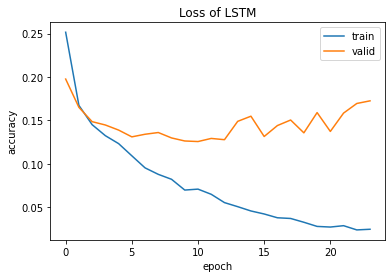

In [ ]:
plot_history(train_l,val_l)

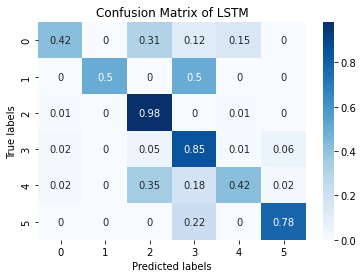

Accuracy Score = 0.8914285714285715
F1 Score (Micro) = 0.8914285714285715
F1 Score (Macro) = 0.6921756596635089


In [ ]:
outputs = test_model ()
outputs = np.argmax(np.array( outputs ), axis=1) 
targets = np.argmax(np.array( list(y_test) ), axis=1) 
plot(targets,outputs,'LSTM')

Surprisingly, with pre-trained embedding, the performance did not improve. We still could not find the reason yet, but we have an assumption —— 10K embedding does not fit for 497K texts. 10K focuses on annual financial performance, and it is for companies. While our texts focus on investment strategies of mutual funds. Plus, more epoches could be done with better computational resources to improve the performance of pre-trained model, as it may not converge now.

## Bert (Fine tuned)

In [ ]:
!pip install -q transformers

     |████████████████████████████████| 3.4 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 28.2 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 61 kB 398 kB/s 
     |████████████████████████████████| 3.3 MB 46.2 MB/s 


In [ ]:
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertModel, BertConfig

In [ ]:
MAX_LEN = 100
TRAIN_BATCH_SIZE = 8
VALID_BATCH_SIZE = 4
EPOCHS = 5
LEARNING_RATE = 1e-05
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
class CustomBertDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.Description = dataframe.Description
        self.targets = dataframe.Class_One_hot
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        Description = str(self.Description[index])
        Description = " ".join(Description.split())

        inputs = self.tokenizer.encode_plus(
            Description,
            None,
            add_special_tokens = True,
            max_length = self.max_len,
            pad_to_max_length = True,
            return_token_type_ids = True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [ ]:
training_set = CustomBertDataset(df_train, tokenizer, MAX_LEN)
testing_set = CustomBertDataset(df_test, tokenizer, MAX_LEN)

In [ ]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
               'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [ ]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.l1 = transformers.BertModel.from_pretrained('bert-base-uncased', return_dict=False)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 7)
    
    def forward(self, ids, mask, token_type_ids):
        _, output_1= self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        return output

model = BERTClass()
model.to(device)

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BERTClass(
  (l1): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    

In [ ]:
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [ ]:
def train(epoch):
    model.train()
    for _,data in enumerate(training_loader):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        outputs = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        if _%1000==0 :
            print(f'Epoch: {epoch}, Num: {_}, Loss:  {loss.item()}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Epoch: 0, Num: 0, Loss:  0.719103217124939
Epoch: 1, Num: 0, Loss:  0.1293797791004181
Epoch: 2, Num: 0, Loss:  0.08375228941440582
Epoch: 3, Num: 0, Loss:  0.08082186430692673
Epoch: 4, Num: 0, Loss:  0.013636122457683086


In [ ]:
def validation():
    # bactch normalization
    model.eval()

    fin_targets=[]
    fin_outputs=[]

    with torch.no_grad():
        for _, data in enumerate(testing_loader):
          
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)

            outputs = model(ids, mask, token_type_ids)

            fin_targets.extend( targets.cpu().detach().numpy().tolist() )
            fin_outputs.extend( torch.sigmoid(outputs).cpu().detach().numpy().tolist() )

    return fin_outputs, fin_targets

In [ ]:
outputs, targets = validation()

We select the highest possible class as the predicted class. This rule could be changed, for example, when two or more possibilities of classes are all closely high, it could be a mixed allocation.

In [ ]:
outputs = np.argmax(outputs, axis=1) 
targets = np.argmax(targets, axis=1) 

In [ ]:
plot(targets,outputs,'Bert')

The training process takes a long time, so previous training outputs are directly pasted here. 

Bert performs even better in classes that has already been classfied well, such as fixed income, equity and money market. But, in classes that did not perform well, it could do nothing as well.

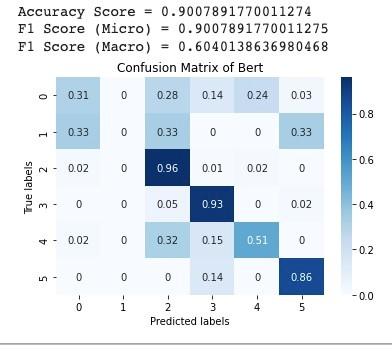

Save the model and data.

In [ ]:
os.chdir('/content/drive/My Drive/4511 industry project/model')
PATH = 'PATH.pth'
torch.save(model.state_dict(), PATH)

os.chdir('/content/drive/My Drive/4511 industry project/output')
df_final = pd.concat( [df_test[['Description']],pd.Series(targets),pd.Series(outputs)] ,axis = 1)
df_final.columns = ['Description','Label','Predicted Label']
df_final.to_csv('bert_output_sec.csv')

Reload the model.

In [ ]:
os.chdir('/content/drive/My Drive/4511 industry project/model')
model.load_state_dict(torch.load('PATH.pth'))

# Potential Improvements




*   Find some regulatory websites for closed-end funds, unit investment trusts, hedge funds, and ETFs. (The vast majority of the funds on SEC are open-end mutual funds)

*   Scrape more funds categories as the training labels to increase the sample size. For example, find commodity funds data from CFTC websites.

*   Try to determine more dimensions, such as sector and geographic allocations, etc.

*   ⚡**Find a better way to clear data and find the exact words we need in the text**. There are still much noise in our data and that greatly undermines our model.

*   ⚡**Adapt the model to Canadian data**. That is to find the description of Canadian funds using their names or other tokens, and try to use trained model to predict. We currently tried Bert on 10 Canadian funds. 4 equity funds are classified correcly, but the other 6 commodities are not.

*   Use some techniques to relieve imbalance problem: downSampling/Upsampling/SMOTE, change weight of loss function...

*   Add more features. For example, in most descriptions of commodity funds the word 'commodity' will appear, so many a new feature could be created to present whether 'commodity' is in the description.

*   Improve the model structure. For example, concat two or more models.

*   ⚡**Rethinking about the categories**. **Fixed allocation** is a special class, as it may contain other classes. Can we find a better way to handle this? 









# Summary

Below are features of our works:

*   **Most of our data requires no fee to gather**. Although we’ve collected 
asset class information from Bloomberg, we also find some open-source and authorized alternatives as mentioned in the data gathering section.

*   **Our model performs extremely well in some classes, and is able to predict using external texts**. For example, “The Fund aims to provide long-term capital growth by investing primarily in Canadian small cap corporations.” is the description of a Canadian fund that invests in equity. Although our model is trained and tested in American funds descriptions from the SEC, it could predict the class to be equity correctly.